# Results

In [1]:
import re
import ast
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from display import display_evolution_metric
from metrics import score, recall, ndcg, mrr

In [2]:
def compute_results(trues, preds_annots):
    data = {}
    for k, preds in preds_annots.items():
        data[k] = score(trues, preds, [recall, ndcg, mrr], k=20)
    df = pd.DataFrame(data).transpose()
    if len(preds_annots)>1:
        df.loc['Mean'] = df.mean()
    return df.round(1)

def select_year(annots, year):
    return {_id: annots[_id] for _id in reading_lists[reading_lists["year"] == year]["id"].to_list() if _id in annots}
    
def compute_results_years(trues, preds_annots):
    data = []
    for year in [2020, 2021, 2022, 2023, 2024]: 
        year_annots = []
        for k, preds in preds_annots.items():
            preds_by_year = select_year(preds, year)
            year_annots.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20))
            data.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20) | {"annotator":k, "year":year})
        data.append(pd.DataFrame(year_annots).mean().to_dict() | {"annotator":"Mean", "year":year})
    df = pd.DataFrame(data).set_index(["year","annotator"])
    return df.round(1)

def load_preds_annotators(path, method):
    preds = defaultdict(lambda: defaultdict(dict))
    for annotator_i in [1,2,3]:
        path_annots = Path(f'{path}/{method}/preds_annot{annotator_i}.json')
        preds[f"A{annotator_i}"] = { id_:[ref["id"] for ref in references] for id_, references in json.loads(path_annots.read_text()).items()}
    return json.loads(json.dumps(preds))

In [3]:
reading_lists = pd.read_csv("../reading_lists.csv")
reading_lists['reading_list'] = reading_lists['reading_list'].apply(ast.literal_eval)

trues = { id_:[ref["paperId"] for ref in references] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }

## Engine comparison using id matching

In [4]:
df_gpt4o = compute_results(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o"))
df_gpt4o_json = compute_results(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o_json"))
df_gpt_structured_output = compute_results(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o-2024-08-06_structured_output"))
df_gemini = compute_results(trues, load_preds_annotators("current_methods/instructs_models/preds", "gemini-1.5-flash"))

table = pd.concat([df_gpt4o, df_gpt4o_json, df_gpt_structured_output, df_gemini], axis=1, keys=["GPT-4o","GPT-4o Json-mode", "GPT-4o Structured Output", "Gemini 1.5 flash"]); table

#print(table.to_latex(float_format="{:0.1f}".format))

GPT-4o             GPT-4o Json-mode            GPT-4o Structured Output  \
     recall  ndcg   mrr           recall ndcg   mrr                   recall   
A1     10.1   9.3  16.6              7.5  8.1  16.6                      6.8   
A2     10.0  11.0  22.4              7.6  7.4  15.5                      6.6   
A3     11.0  11.8  24.4              7.9  8.4  17.8                      6.6   
Mean   10.3  10.7  21.1              7.7  8.0  16.6                      6.7   

                Gemini 1.5 flash             
     ndcg   mrr           recall ndcg   mrr  
A1    8.7  18.0              7.1  9.9  13.8  
A2    6.8  14.6              4.7  5.3   9.8  
A3    8.4  17.2              6.2  8.4  11.3  
Mean  8.0  16.6              6.0  7.9  11.6

### Comparison by years

In [11]:
df_gpt4o = compute_results_years(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o"))
df_gpt4o_json = compute_results_years(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o_json"))
df_gpt_structured_output = compute_results_years(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o-2024-08-06_structured_output"))
df_gemini = compute_results_years(trues, load_preds_annotators("current_methods/instructs_models/preds", "gemini-1.5-flash"))

table_years = pd.concat([df_gpt4o, df_gpt4o_json, df_gpt_structured_output, df_gemini], axis=1, keys=["GPT-4o","GPT-4o Json", "GPT-4o SO", "Gemini 1.5 flash"]); table_years

#print(table_years.to_latex(float_format="{:0.1f}".format))

GPT-4o             GPT-4o Json             GPT-4o SO        \
               recall  ndcg   mrr      recall  ndcg   mrr    recall  ndcg   
year annotator                                                              
2020 A1           8.5   7.8  13.1         4.3   3.9   6.4       5.9   5.0   
     A2          13.4  15.7  30.3        10.3   9.1  17.0       7.6   8.0   
     A3          12.0  13.8  30.9         9.6   9.5  20.4      11.2  13.6   
     Mean        11.3  12.4  24.8         8.1   7.5  14.6       8.2   8.9   
2021 A1          13.4  13.4  24.2        13.3  13.7  24.5      11.0  11.9   
     A2           7.9  10.0  25.4         3.5   4.2  11.0       7.6   6.9   
     A3           8.9  10.2  27.2         9.0   9.8  21.2       6.0   6.5   
     Mean        10.1  11.2  25.6         8.6   9.2  18.9       8.2   8.5   
2022 A1          10.7  10.0  19.6        11.4  14.3  32.6      10.7  17.3   
     A2          13.7  15.0  32.9        15.0  16.6  35.5      12.2  14.3   
     A3          13.7  16.4  33.3        14.1  16.7  36.5      11.7  16.4   
     Mean        12.7  13.8  28.6        13.5  15.8  34.9      11.5  16.0   
2023 A1           1.2   1.8   9.0         0.5   1.2   7.7       2.6   3.9   
     A2           3.2   2.6   3.7         1.2   1.0   2.6       0.5   0.3   
     A3           4.1   3.8  10.6         0.0   0.0   0.0       0.0   0.0   
     Mean         2.8   2.7   7.8         0.5   0.7   3.4       1.0   1.4   
2024 A1           4.8   4.0   7.7         1.7   0.9   1.1       0.0   0.0   
     A2           2.4   2.9   6.7         4.5   2.8   4.3       0.0   0.0   
     A3           4.1   4.1   7.1         2.3   1.2   1.3       0.0   0.0   
     Mean         3.8   3.7   7.1         2.8   1.6   2.2       0.0   0.0   

                     Gemini 1.5 flash              
                 mrr           recall  ndcg   mrr  
year annotator                                     
2020 A1          8.4              7.4   8.4  20.1  
     A2         14.8              7.1   9.4  14.0  
     A3         27.3              4.8   7.7  12.5  
     Mean       16.8              6.4   8.5  15.5  
2021 A1         23.4             15.5  14.3  19.9  
     A2         14.7              5.7   6.3  12.9  
     A3         13.1             11.7  11.7  16.8  
     Mean       17.1             11.0  10.8  16.5  
2022 A1         32.9              6.0   6.7  13.2  
     A2         33.9              8.9   9.1  18.4  
     A3         34.2              8.2   8.5  14.9  
     Mean       33.7              7.7   8.1  15.5  
2023 A1         16.5              0.0   0.0   0.0  
     A2          0.4              0.0   0.0   0.0  
     A3          0.0              0.0   0.0   0.0  
     Mean        5.6              0.0   0.0   0.0  
2024 A1          0.0              0.0   0.0   0.0  
     A2          0.0              0.0   0.0   0.0  
     A3          0.0              2.2   7.6   3.3  
     Mean        0.0              0.7   2.5   1.1

### Recall evolution by years

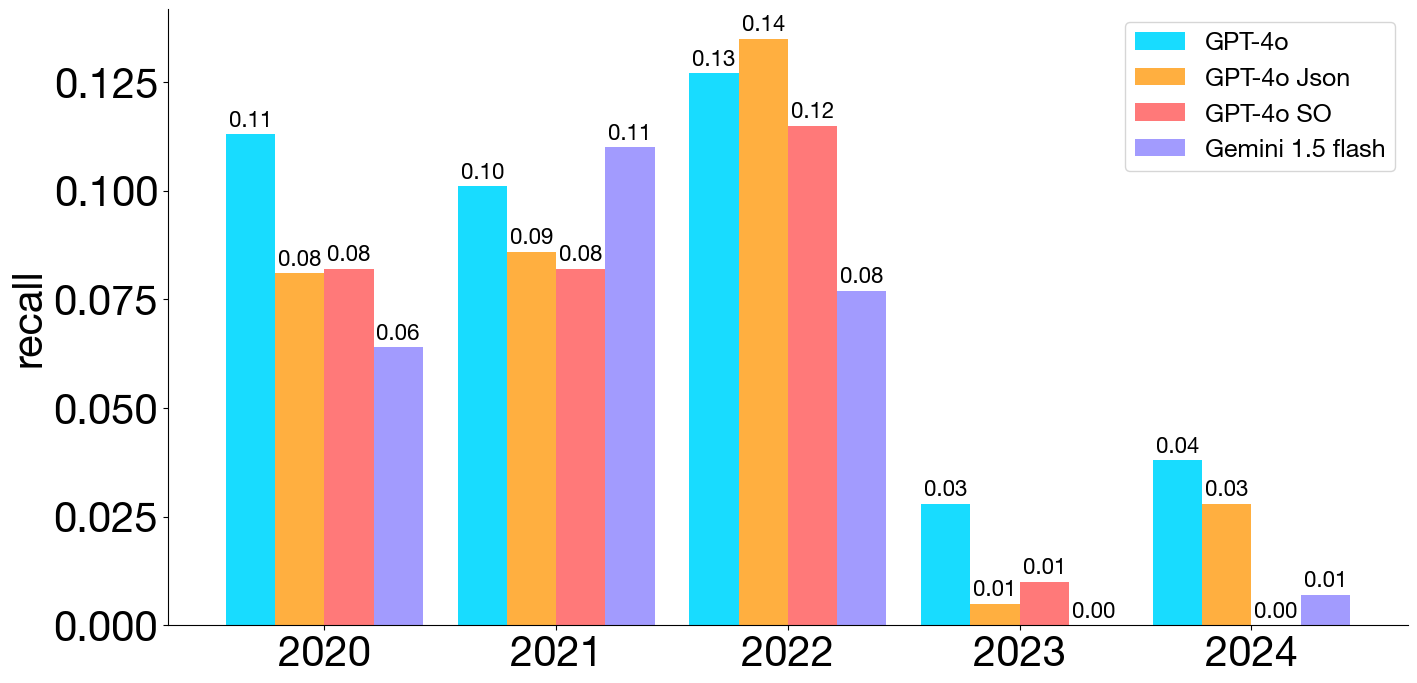

In [12]:
display_evolution_metric(table_years, ["GPT-4o","GPT-4o Json", "GPT-4o SO", "Gemini 1.5 flash"], "recall")